Cheng Shi; USCID: 8556138235; Github:CaronShi

In [29]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import cv2
import os
#import splitfolders
import random
from tensorflow.keras.layers import Dense, Input, Activation, add, Add, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#gpus = tf.config.list_physical_devices ('GPU')

In [30]:
classes = pd.read_excel('Data/Classes.xlsx', index_col=0)  
class_name = list(classes.index.values.tolist() )
#classes.index.name
class_list = classes["Class"].tolist()
path = os.getcwd()

One-hot Encoding

In [31]:

#splitfolders.ratio(path, output="output", seed=1337, ratio=(.7, 0.15,0.15))

In [69]:
dataset_dir = path+'/output/'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')


#To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast,and translate images in your training set for image augmentation.
train_data_gen = ImageDataGenerator( 
                                    vertical_flip=True,
                                    horizontal_flip = True,
                                    rotation_range = 30,
                                    channel_shift_range = 10,
                                    zoom_range = random.random(),
                                    fill_mode = 'nearest',
                                    brightness_range=[0.2,1.0],)
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

num_classes=20
seed = 42

train_gen = train_data_gen.flow_from_directory(train_dir,
                                               target_size = (224, 224),
                                               #save_to_dir = path +'/retrain',
                                      class_mode = 'categorical',
                                      subset = 'training',
                                               seed = seed,
                                      color_mode="rgb",)
test_gen = test_data_gen.flow_from_directory(test_dir,
                                        target_size = (224, 224),
                                      class_mode = 'categorical',
                                      subset = 'training',
                                    seed = seed,
                                      color_mode="rgb",)

val_gen = valid_data_gen.flow_from_directory(val_dir,
                                    target_size = (224, 224),
                                      class_mode = 'categorical',
                                        seed = seed,
                                      subset = 'training',
                                      color_mode="rgb",)


Found 820 images belonging to 20 classes.
Found 185 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [73]:
for i in range(0,len(train_gen)):
    if i==0:
        print('sample one-hot encoding for training data\n',train_gen[i][1])

sample one-hot encoding for training data
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0

In [35]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

# Create Model
model_ENB0 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
model_ENB0.trainable = False
model_ENB0.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation) 

 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
          

 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization) 

                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_d

In [36]:

#from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(model_ENB0)
model.add(GlobalAveragePooling2D(name="avg_pool"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(20,activation="relu"))
model.add(tf.keras.layers.Softmax())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_2 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                25620     
                                                                 
 softmax_2 (Softmax)         (None, 20)               

In [37]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss = 'categorical_crossentropy',      
              optimizer = optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy',f1_m,precision_m, recall_m]
             )

In [38]:
#https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
checkpoint_filepath = path
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
       mode = "min",
    save_best_only=True)

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

history = model.fit(train_gen, 
                    validation_data= val_gen, 
                    epochs=100,callbacks=[model_checkpoint_callback,early])


Epoch 1/100
26/26 [==============================] - 18s 569ms/step - loss: 2.4214 - accuracy: 0.4220 - f1_m: 0.4200 - precision_m: 0.4962 - recall_m: 0.3719 - val_loss: 1.2534 - val_accuracy: 0.7135 - val_f1_m: 0.5154 - val_precision_m: 0.8795 - val_recall_m: 0.3688
Epoch 2/100
26/26 [==============================] - 14s 522ms/step - loss: 1.5041 - accuracy: 0.6768 - f1_m: 0.6859 - precision_m: 0.7155 - recall_m: 0.6591 - val_loss: 0.9253 - val_accuracy: 0.7485 - val_f1_m: 0.6487 - val_precision_m: 0.8392 - val_recall_m: 0.5341
Epoch 3/100
26/26 [==============================] - 14s 520ms/step - loss: 1.1457 - accuracy: 0.7402 - f1_m: 0.7442 - precision_m: 0.7766 - recall_m: 0.7151 - val_loss: 0.7550 - val_accuracy: 0.7485 - val_f1_m: 0.7530 - val_precision_m: 0.8652 - val_recall_m: 0.6690
Epoch 4/100
26/26 [==============================] - 14s 522ms/step - loss: 1.0926 - accuracy: 0.7720 - f1_m: 0.7747 - precision_m: 0.7938 - recall_m: 0.7572 - val_loss: 0.6819 - val_accuracy: 0.8

26/26 [==============================] - 14s 518ms/step - loss: 0.6102 - accuracy: 0.8671 - f1_m: 0.8825 - precision_m: 0.9104 - recall_m: 0.8567 - val_loss: 0.7474 - val_accuracy: 0.8596 - val_f1_m: 0.8797 - val_precision_m: 0.8846 - val_recall_m: 0.8750
Epoch 32/100
26/26 [==============================] - 13s 510ms/step - loss: 0.6038 - accuracy: 0.8671 - f1_m: 0.8759 - precision_m: 0.9010 - recall_m: 0.8529 - val_loss: 1.1558 - val_accuracy: 0.8246 - val_f1_m: 0.8338 - val_precision_m: 0.8338 - val_recall_m: 0.8338
Epoch 33/100
26/26 [==============================] - 13s 508ms/step - loss: 0.7160 - accuracy: 0.8427 - f1_m: 0.8577 - precision_m: 0.8807 - recall_m: 0.8365 - val_loss: 0.9786 - val_accuracy: 0.8363 - val_f1_m: 0.8365 - val_precision_m: 0.8388 - val_recall_m: 0.8343
Epoch 34/100
26/26 [==============================] - 13s 513ms/step - loss: 0.6083 - accuracy: 0.8512 - f1_m: 0.8640 - precision_m: 0.8926 - recall_m: 0.8377 - val_loss: 0.8779 - val_accuracy: 0.8713 - val

In [39]:
#EffiecientB0 model scores
l,a,f1,p,r = model.evaluate(test_gen)
print("loss:",l,"\naccuracy:",a,"\nf1:",f1,"\nprecision:",p,"\nrecall:",r)

6/6 [==============================] - 2s 278ms/step - loss: 1.1965 - accuracy: 0.8054 - f1_m: 0.8050 - precision_m: 0.8094 - recall_m: 0.8008
loss: 1.1965019702911377 
accuracy: 0.8054053783416748 
f1: 0.805049479007721 
precision: 0.80940181016922 
recall: 0.8008332848548889


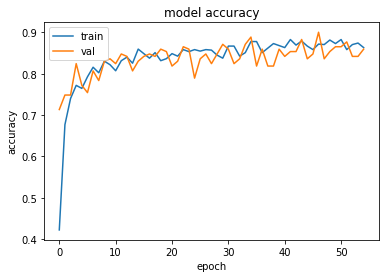

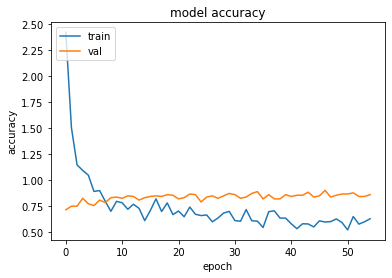

In [40]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
train_data_gen = ImageDataGenerator( rescale = 1./255,
                                    vertical_flip=True,
                                    horizontal_flip = True,
                                    rotation_range = 30,
                                    channel_shift_range = 10,
                                    zoom_range = random.random(),
                                    fill_mode = 'nearest',
                                    brightness_range=[0.2,1.0],
                                   preprocessing_function = preprocess_input)
valid_data_gen = ImageDataGenerator(rescale = 1./255,preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(rescale = 1./255,preprocessing_function = preprocess_input)

num_classes=20
seed = 42

train_gen = train_data_gen.flow_from_directory(train_dir,
                                               target_size = (224, 224),
                                               #save_to_dir = path +'/retrain',
                                      class_mode = 'categorical',
                                      subset = 'training',
                                               seed = seed,
                                      color_mode="rgb",)
test_gen = test_data_gen.flow_from_directory(test_dir,
                                        target_size = (224, 224),
                                      class_mode = 'categorical',
                                      subset = 'training',
                                    seed = seed,
                                      color_mode="rgb",)

val_gen = valid_data_gen.flow_from_directory(val_dir,
                                    target_size = (224, 224),
                                      class_mode = 'categorical',
                                        seed = seed,
                                      subset = 'training',
                                      color_mode="rgb",)

Found 820 images belonging to 20 classes.
Found 185 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [49]:
model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
model_vgg.trainable = False

model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [51]:
last_layer = model_vgg.get_layer('block5_pool')
last_output = model_vgg.output

x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(20, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(model_vgg.input, x)
model.summary()
model.compile(loss = 'categorical_crossentropy',      
              optimizer = optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy',f1_m,precision_m, recall_m]
             )

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [52]:
checkpoint_filepath = path
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode="min",
    save_best_only=True)

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

history = model.fit(train_gen, 
                    validation_data= val_gen, 
                    epochs=100,
                    callbacks =[model_checkpoint_callback, early])

Epoch 1/100
26/26 [==============================] - 30s 1s/step - loss: 3.3728 - accuracy: 0.1171 - f1_m: 0.0618 - precision_m: 0.1660 - recall_m: 0.0397 - val_loss: 2.9175 - val_accuracy: 0.1404 - val_f1_m: 0.0395 - val_precision_m: 0.4167 - val_recall_m: 0.0208
Epoch 2/100
26/26 [==============================] - 29s 1s/step - loss: 2.7488 - accuracy: 0.2293 - f1_m: 0.1740 - precision_m: 0.4690 - recall_m: 0.1094 - val_loss: 2.6391 - val_accuracy: 0.2807 - val_f1_m: 0.1663 - val_precision_m: 0.6486 - val_recall_m: 0.0985
Epoch 3/100
26/26 [==============================] - 29s 1s/step - loss: 2.6404 - accuracy: 0.2573 - f1_m: 0.1992 - precision_m: 0.5557 - recall_m: 0.1236 - val_loss: 2.8468 - val_accuracy: 0.2105 - val_f1_m: 0.1544 - val_precision_m: 0.3093 - val_recall_m: 0.1037
Epoch 4/100
26/26 [==============================] - 29s 1s/step - loss: 2.4509 - accuracy: 0.3256 - f1_m: 0.2818 - precision_m: 0.6489 - recall_m: 0.1834 - val_loss: 2.3924 - val_accuracy: 0.3392 - val_f1

Epoch 32/100
26/26 [==============================] - 29s 1s/step - loss: 2.1456 - accuracy: 0.4110 - f1_m: 0.4327 - precision_m: 0.7644 - recall_m: 0.3070 - val_loss: 1.9269 - val_accuracy: 0.5439 - val_f1_m: 0.5032 - val_precision_m: 0.5973 - val_recall_m: 0.4366
Epoch 33/100
26/26 [==============================] - 29s 1s/step - loss: 2.0653 - accuracy: 0.4317 - f1_m: 0.4608 - precision_m: 0.7275 - recall_m: 0.3411 - val_loss: 1.8724 - val_accuracy: 0.5789 - val_f1_m: 0.5733 - val_precision_m: 0.7038 - val_recall_m: 0.4872
Epoch 34/100
26/26 [==============================] - 29s 1s/step - loss: 2.2235 - accuracy: 0.4110 - f1_m: 0.3949 - precision_m: 0.6883 - recall_m: 0.2825 - val_loss: 1.7085 - val_accuracy: 0.5673 - val_f1_m: 0.5953 - val_precision_m: 0.7319 - val_recall_m: 0.5028
Epoch 35/100
26/26 [==============================] - 29s 1s/step - loss: 2.1278 - accuracy: 0.4073 - f1_m: 0.4209 - precision_m: 0.7265 - recall_m: 0.2993 - val_loss: 1.9482 - val_accuracy: 0.5673 - va

Epoch 63/100
26/26 [==============================] - 29s 1s/step - loss: 1.9316 - accuracy: 0.4768 - f1_m: 0.4868 - precision_m: 0.7570 - recall_m: 0.3623 - val_loss: 1.7203 - val_accuracy: 0.6023 - val_f1_m: 0.6037 - val_precision_m: 0.7096 - val_recall_m: 0.5284
Epoch 64/100
26/26 [==============================] - 29s 1s/step - loss: 2.0201 - accuracy: 0.4439 - f1_m: 0.4693 - precision_m: 0.7243 - recall_m: 0.3517 - val_loss: 1.7192 - val_accuracy: 0.5556 - val_f1_m: 0.5551 - val_precision_m: 0.7032 - val_recall_m: 0.4659
Epoch 65/100
26/26 [==============================] - 29s 1s/step - loss: 2.0232 - accuracy: 0.4415 - f1_m: 0.4609 - precision_m: 0.7632 - recall_m: 0.3349 - val_loss: 1.7102 - val_accuracy: 0.6199 - val_f1_m: 0.6259 - val_precision_m: 0.7543 - val_recall_m: 0.5379
Epoch 66/100
26/26 [==============================] - 29s 1s/step - loss: 2.0394 - accuracy: 0.4476 - f1_m: 0.4567 - precision_m: 0.7700 - recall_m: 0.3284 - val_loss: 1.7588 - val_accuracy: 0.5497 - va

Epoch 94/100
26/26 [==============================] - 29s 1s/step - loss: 1.9488 - accuracy: 0.4732 - f1_m: 0.4795 - precision_m: 0.7348 - recall_m: 0.3599 - val_loss: 1.5402 - val_accuracy: 0.5848 - val_f1_m: 0.6200 - val_precision_m: 0.7549 - val_recall_m: 0.5284
Epoch 95/100
26/26 [==============================] - 29s 1s/step - loss: 1.9955 - accuracy: 0.4671 - f1_m: 0.4800 - precision_m: 0.7408 - recall_m: 0.3615 - val_loss: 1.6180 - val_accuracy: 0.5673 - val_f1_m: 0.6025 - val_precision_m: 0.7087 - val_recall_m: 0.5275
Epoch 96/100
26/26 [==============================] - 29s 1s/step - loss: 1.9981 - accuracy: 0.4683 - f1_m: 0.4719 - precision_m: 0.7410 - recall_m: 0.3495 - val_loss: 1.7160 - val_accuracy: 0.5731 - val_f1_m: 0.5801 - val_precision_m: 0.6786 - val_recall_m: 0.5080
Epoch 97/100
26/26 [==============================] - 29s 1s/step - loss: 1.9802 - accuracy: 0.4598 - f1_m: 0.4854 - precision_m: 0.7218 - recall_m: 0.3700 - val_loss: 1.7400 - val_accuracy: 0.5731 - va

In [54]:
l1,a1,f11,p1,r1 = model.evaluate(test_gen)
print("loss:",l1,"\naccuracy:",a1,"\nf1:",f11,"\nprecision:",p1,"\nrecall:",r1)

6/6 [==============================] - 5s 854ms/step - loss: 1.6990 - accuracy: 0.5892 - f1_m: 0.5982 - precision_m: 0.7519 - recall_m: 0.4981
loss: 1.6989918947219849 
accuracy: 0.5891891717910767 
f1: 0.5982157588005066 
precision: 0.751945972442627 
recall: 0.49812498688697815


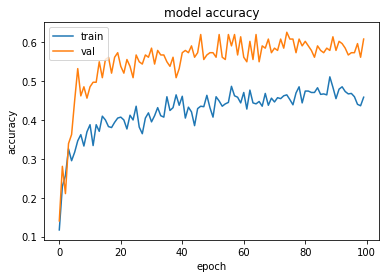

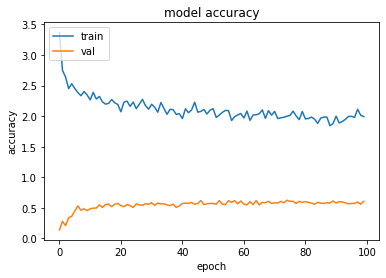

In [64]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
result = pd.DataFrame()

result["EfficientNetB0"] = l,a,f1,p1,r1
result["VGG16"] = l1,a1,f11,p1,r1
result['scores'] = 'Loss','Accuracy','F1','Precision','Recall'

result = result.set_index('scores')
result

,EfficientB0,VGG16
scores,,
loss,1.196502,1.698992
accuracy,0.805405,0.589189
f1,0.805049,0.598216
precision,0.751946,0.751946
recall,0.498125,0.498125
